#  Transformer-based Stock Price Prediction with MCES & Fuzzy Logic

In [13]:
# 🛠️ Imports & Setup
import os, pickle
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datetime import date
from tqdm.auto import tqdm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

In [14]:
# ⚙️ Configurations
ticker = 'C38U.SI'
PRED_PERIOD = 13
PERIOD = 14
wkdir = f'/home/priya/Desktop/fyp/Src alwin/Src/data/{ticker}'
MCES_START = date(1988, 1, 1)
MCES_END = date(2018, 1, 1)


from datetime import date 

INITIALIZATION_MIN = 5

CLUSTER_MAXCLUSTERS = 15
CLUSTER_MINCLUSTERS = 15
FACTOR = 2

MERGED_MIN_STD = 2
MERGED_MIN = 4
MERGED_MAX = 8

MERGED_YMAX = 8
MERGED_MINY_STD = 2


MAX_LAYERS = 4

MCES_START = date(1988, 1, 1)
MCES_END = date(2018, 1, 1)

ZERO_REPLACEMENT = 0.0001 
PERIOD = 14
PRED_PERIOD = 13
TEST_START = date(2019, 1, 1)
TEST_END = date(2025, 1, 1)
VAL_START = date(2018, 1, 1)

In [15]:
# 📥 Load Data
ftraindf = pd.read_csv(f'/home/priya/Desktop/fyp/Src alwin/Src/data/{ticker}/ftraindf.csv')
fvaldf = pd.read_csv(f'/home/priya/Desktop/fyp/Src alwin/Src/data/{ticker}/fvaldf.csv')
ftestdf = pd.read_csv(f'/home/priya/Desktop/fyp/Src alwin/Src/data/{ticker}/ftestdf.csv')

with open(f'/home/priya/Desktop/fyp/Src alwin/Src/data/{ticker}/cluster_details.pkl', 'rb') as handle:
    cluster_details = pickle.load(handle)

print("✅ Data & cluster details loaded")

✅ Data & cluster details loaded


In [16]:
# 📊 Load Selected Features
features_path = f"/home/priya/Desktop/fyp/Src alwin/Src/data/{ticker}/features_selected.pkl"
with open(features_path, "rb") as handle:
    features_selected = pickle.load(handle)
print(f"✅ Loaded feature selection for {ticker}")

✅ Loaded feature selection for C38U.SI


In [17]:

model_dict = {
    plus_target: {
        'model_type': 'transformer',
        'transformer': {
            'd_model': 128,
            'shuffle': True,  
            'nhead': 7,
            'num_encoder_layers': 2,
            'dim_feedforward': 256,
            'dropout': 0.2,
            'activation': 'gelu',
            'positional_encoding': 'sinusoidal',
            'batch_first': True,
            'hidden_size': 128,         # ✅ add this
            'dense_layers': 2  
        },
        'optimizer': {
            'optim_type': 'adamw',
            'learning_rate': 1e-4, #1e-4
            'weight_decay': 1e-5,
            'scheduler': 'cosine',
        },
        'early_stopper': {
            'patience': 10,
            'min_delta': 0
        },
        'loss_fn': 'HuberLoss', # MSE loss
        'epochs': 100,
        'batch_size': 64,
        'input_size': len(features_selected[plus_target]),
        'output_size': 1,
        'day_target': plus_target,
        'verbose': 0,
        'seed': 42,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }
    for plus_target in range(1, PRED_PERIOD + 1)
}


/home/priya/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [18]:
import pandas as pd 
from sklearn.metrics import r2_score, mean_squared_error
import sys, os 
sys.path.append(os.getcwd())
from s1_data_preparation.config import *

def evaluateModel(outcome, trainset, valset, testset, cluster_details, header, plus_target): 
    
    eval_res = {}
    print("Starting model evaluation...")
    
    for result in outcome: 
        print(f"Processing result: {result}")

        # if result == 'train_pred': continue

        mode = 0

        ## normalization 
        pred_res = outcome[result].copy()
        print(f"Initial prediction results for {result}:\n", pred_res.head())
        
        if result == 'val_pred': 
            reference = valset['ref']
        elif result == 'test_pred': 
            reference = testset['ref']
        else: 
            reference = trainset['ref']
        print(f"Reference data for {result}:\n", reference.head())
        
        cols = list(pred_res.columns)
        print(f"Prediction columns: {cols}")

        if mode == 0: 
            print("Applying normalization mode 0...")
            
            pred_res['summation'] = pred_res.apply(lambda x: sum(x), axis=1)
            for col in cols: 
                pred_res[col] = pred_res.apply(lambda x: round(x[col]/x['summation'], 6), axis=1)
            
            pred_res = pred_res.drop(['summation'], axis=1) 
            print(f"Normalized predictions: \n", pred_res.head())

        if mode == 1: 
            print("Applying normalization mode 1...")
            pred_res['maximum'] = pred_res.apply(lambda x: max(x), axis=1)
            for col in cols: 
                pred_res[col] = pred_res.apply(lambda x: 1 if x[col] == x['maximum'] else 0, axis=1)
            
        ## defuzzify 
        print("Performing defuzzification...")
        pred_res['pc_pred'] = 0 
        for col in cols: 
            pred_res['pc_pred'] = pred_res.apply(lambda x: x['pc_pred'] + x[col]*cluster_details[header][col]['mean'], axis=1)
        print(f"Defuzzified predictions: \n", pred_res.head())
        
        # price change 
        print("Calculating price predictions...")
        price_pred = pd.concat([pred_res, reference[[f'refPrice_Tm{period}', f'yref_Tp{plus_target}_Price', f'ypcref_Tp{plus_target}_PriceChg']]], axis=1)
        price_pred['price_pred'] = price_pred.apply(lambda x: x[f'refPrice_Tm{period}']*(1+x['pc_pred']), axis=1) 
        price_pred = price_pred[[f'yref_Tp{plus_target}_Price', 'price_pred', f'ypcref_Tp{plus_target}_PriceChg', 'pc_pred']]
        price_pred['error'] = price_pred.apply(lambda x: abs(x['price_pred'] - x[f'yref_Tp{plus_target}_Price'])/x[f'yref_Tp{plus_target}_Price'], axis=1)
        print(f"Price prediction results: \n", price_pred.head())

        pred_r2 = r2_score(price_pred[f'yref_Tp{plus_target}_Price'], price_pred['price_pred'])
        pred_rmse = mean_squared_error(price_pred[f'yref_Tp{plus_target}_Price'], price_pred['price_pred'])**0.5
        print(f"Metrics - RMSE: {pred_rmse}, R2: {pred_r2}, MAPE: {price_pred['error'].mean()}")

        eval_res[result] = {
            'rmse': pred_rmse, 
            'r2': pred_r2, 
            'mape': price_pred['error'].mean(), 
            'predicted': reference, 
            'ref': price_pred, 
            'cluster_ref': pred_res
        }
    
    print("Model evaluation completed.")
    return eval_res

In [20]:

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping
import pandas as pd 


def mlpConstructor(model_dict): 

    nn = Sequential()

    for layer in model_dict['mlp']['layers']: 

        nodes = model_dict['mlp']['layers'][layer]['nodes']
        activation = model_dict['mlp']['hl_activation']

        if layer == 0: nn.add(Dense(nodes, input_dim = model_dict['input_size'], activation = activation))
        else: nn.add(Dense(nodes, activation = activation))
    
    # add output layer 
    activation = model_dict['mlp']['ol_activation']
    nn.add(Dense(model_dict['output_size'], activation = activation))    
    
    # compile model 
    if activation == 'linear': nn.compile(loss = 'mse', optimizer = model_dict['mlp']['optimizer']['optim_type'])
    # elif activation == 'sigmoid': nn.compile(loss = 'binary_crossentropy', optimizer =  model_dict['mlp']['optimizer']['optim_type'], metrics = ['binary_accuracy'])
    # elif activation == 'softmax': nn.compile(loss = 'categorical_crossentropy', optimizer =  model_dict['mlp']['optimizer']['optim_type'], metrics = ['accuracy'])
    elif activation == 'sigmoid': nn.compile(loss = 'mse', optimizer =  model_dict['mlp']['optimizer']['optim_type'])
    elif activation == 'softmax': nn.compile(loss = 'categorical_crossentropy', optimizer =  model_dict['mlp']['optimizer']['optim_type'], metrics = ['accuracy'])


    return nn

# kerasTrain function 
# kerasTrain function
def kerasTrain(model, model_dict, cluster_details, trainset, valset, testset, header):

    es = None 
    # early stopper
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience = model_dict['early_stopper']['patience'], min_delta=model_dict['early_stopper']['min_delta'])

    # model fit
    if es!= None: model.fit(trainset['X'], trainset['y'], epochs = model_dict['epochs'], batch_size = model_dict['batch_size'], shuffle = model_dict['mlp']['shuffle'], verbose = model_dict['mlp']['verbose'], validation_data = (valset['X'], valset['y']), callbacks=[es])
    else: model.fit(trainset['X'], trainset['y'], epochs = model_dict['epochs'], batch_size = model_dict['batch_size'], shuffle = model_dict['mlp']['shuffle'], verbose = model_dict['mlp']['verbose'], validation_data = (valset['X'], valset['y']))
    val_pred = model.predict(valset['X'], verbose = model_dict['mlp']['verbose'])
    test_pred = model.predict(testset['X'], verbose = model_dict['mlp']['verbose'])

    val_pred = pd.DataFrame(val_pred, columns = valset['y'].columns, index = valset['y'].index)
    test_pred = pd.DataFrame(test_pred, columns = testset['y'].columns, index = testset['y'].index)

    return model, val_pred, test_pred


2025-04-01 19:53:16.956872: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:


import sys, os, copy, random
import pandas as pd 
import torch, pickle
import gc

# from tqdm import tqdm 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from tqdm.auto import tqdm

sys.path.append(os.getcwd())
from s1_data_preparation.config import *
from s2_crystal_ball.config import *
from s2_crystal_ball.keras_neural import mlpConstructor, kerasTrain
from s2_crystal_ball.pytorch_neural import Transformer, pytorchTrain, MLP
from s2_crystal_ball.evaluation import evaluateModel
from s2_crystal_ball.mces import mcesPipeline

def neuralDataPreparation(ftraindf, fvaldf, ftestdf, period = PERIOD, plus_target = 1): 

    x_cols = [col for col in ftraindf.columns if 'x_' in col]
    y_cols = [col for col in ftraindf.columns if f'y_Tp{plus_target}_PriceChg_' in col]
    ref_cols = [col for col in ftraindf.columns if f'yref_Tp{plus_target}_Price' in col or f'refPrice_Tm{period}' in col or f'ypcref_Tp{plus_target}_PriceChg' in col or f'yref_Tp{plus_target}_Date' in col or 'yref_Tm0_close' in col]


    trainset = {'X': ftraindf[x_cols], 'y': ftraindf[y_cols], 'ref': ftraindf[ref_cols]}
    valset = {'X': fvaldf[x_cols], 'y': fvaldf[y_cols], 'ref': fvaldf[ref_cols]}
    testset = {'X': ftestdf[x_cols], 'y': ftestdf[y_cols], 'ref': ftestdf[ref_cols]}
    
    return trainset, valset, testset    


def neuralConstructor(model_dict): 

    model = None 

    if model_dict['model_type'] == 'mlp': model = mlpConstructor(model_dict)
    # elif model_dict['model_type'] == 'rnn': model = rnnConstructor(model_dict)
    elif model_dict['model_type'] == 'transformer': model = Transformer(model_dict)

    return model 


def monoNeuralPipeline(ftraindf, fvaldf, ftestdf, model_dict, cluster_details, plus_target=1, chosen_features=None, mode=0):
    import torch, gc, pickle

    header = f'y_Tp{plus_target}_PriceChg'

    # Step 1: Feature selection and data preparation
    if mode == 1:
        rftraindf, rfvaldf, rftestdf, featureSelection = mces(
            ftraindf, fvaldf, ftestdf, cluster_details, plus_target, chosen_features
        )
        trainset, valset, testset = neuralDataPreparation(rftraindf, rfvaldf, rftestdf, plus_target=plus_target)
    else:
        trainset, valset, testset = neuralDataPreparation(ftraindf, fvaldf, ftestdf, plus_target=plus_target)

    # Step 2: Update model_dict[plus_target]
    model_dict['input_size'] = len(trainset['X'].columns)
    model_dict['output_size'] = len(trainset['y'].columns)
    model_dict['day_target'] = plus_target

    model_type = model_dict.get('model_type', 'transformer')

    # Step 3: Build model
    if model_type == 'transformer':
        input_size = model_dict['input_size']
        # Find valid nhead values that divide input_size
        nhead_options = [i for i in range(1, 11) if input_size % i == 0]
        nhead = max(nhead_options) if nhead_options else 1

        # Ensure d_model is divisible by nhead
        d_model = input_size if input_size % nhead == 0 else ((input_size // nhead) + 1) * nhead

        # Update model_dict transformer settings
        model_dict['transformer']['nhead'] = nhead
        model_dict['transformer']['d_model'] = d_model

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = neuralConstructor(model_dict).to(device)

        # Train using PyTorch
        model, train_pred, val_pred, test_pred = pytorchTrain(
            model=model,
            model_dict=model_dict,
            trainset=trainset,
            valset=valset,
            testset=testset,
            traintype=0
        )
    else:
        # MLP or other models (using Keras backend)
        model = neuralConstructor(model_dict)
        model, train_pred, val_pred, test_pred = kerasTrain(
            model, model_dict, cluster_details, trainset, valset, testset, header
        )

    # Step 4: Store predictions
    outcome = {
        'train_pred': train_pred,
        'val_pred': val_pred,
        'test_pred': test_pred
    }

    # Step 5: Reload cluster details
    ticker = 'C38U.SI'
    with open(f'/home/priya/Desktop/fyp/Src alwin/Src/data/{ticker}/cluster_details.pkl', 'rb') as handle:
        cluster_details = pickle.load(handle)
    print("Reloaded cluster_details")

    # Step 6: Evaluate model
    eval_res = evaluateModel(
        outcome=outcome,
        trainset=trainset,
        valset=valset,
        testset=testset,
        cluster_details=cluster_details,
        header=header,
        plus_target=plus_target
    )
    eval_res['header'] = header

    gc.collect()

    return model, eval_res

def optimizeMonoNetwork(ftraindf, fvaldf, ftestdf, cluster_details, plus_target): 
    model_type = 'transformer'
    configurations = generateConfigurations(model_type, ftraindf)

    models = [] 
    val_performance_r2 = []
    val_performance_rmse = []
    test_performance_r2 = []     
    test_performance_rmse = [] 

    for configuration in tqdm(configurations): 
        print(configuration)
        model, eval_res = monoNeuralPipeline(
            ftraindf, fvaldf, ftestdf, configuration, cluster_details, plus_target
        )
        models.append(model)
        val_performance_r2.append(eval_res['val_pred']['r2'])
        val_performance_rmse.append(eval_res['val_pred']['rmse'])
        test_performance_r2.append(eval_res['test_pred']['r2'])
        test_performance_rmse.append(eval_res['test_pred']['rmse'])

    index = val_performance_rmse.index(min(val_performance_rmse))
    optimal_config = configurations[index]
    optimal_model = models[index]

    print(f'Optimal Config {index} - val_r2: {val_performance_r2[index]}, val_rmse: {val_performance_rmse[index]} | test_r2: {test_performance_r2[index]}, test_rmse: {test_performance_rmse[index]}')

    results_df = pd.DataFrame({
        'val_r2': val_performance_r2,
        'val_rmse': val_performance_rmse,
        'test_r2': test_performance_r2,
        'test_rmse': test_performance_rmse,
        'configuration': [str(c) for c in configurations]
    })
    results_df.to_csv(f'performance_summary_Tp{plus_target}.csv', index=False)
    print(f"✅ Saved performance summary to performance_summary_Tp{plus_target}.csv")

    return optimal_model, optimal_config

def generateConfigurations(model_type, ftraindf):
    configurations = []
    x_cols = [col for col in ftraindf if 'x_' in col]

    if model_type == 'transformer': 
        dim_feedforward = [128, 256]
        num_encoder_layers = [2, 4, 6]
        batch_sizes = [64, 128]
        nheads = [i for i in range(1, 9) if len(x_cols) % i == 0]

        for dim in dim_feedforward: 
            for encoder_layer in num_encoder_layers: 
                for batch_size in batch_sizes: 
                    for nhead in nheads: 
                        instance = {
                            'model_type': 'transformer',
                            'transformer': {
                                'dim_feedforward': dim,
                                'num_encoder_layers': encoder_layer,
                                'nhead': nhead,
                                'shuffle': False,
                                'dropout': 0.2,
                                'activation': 'gelu',
                                'batch_first': True,
                                'hidden_size': 128,
                                'dense_layers': 3,
                                'd_model': 128,  # Make sure this is divisible by nhead
                                'positional_encoding': 'sinusoidal'
                            },
                            'optimizer': {
                                'optim_type': 'adam',
                                'learning_rate': 3e-4,
                                'weight_decay': 1e-5,
                                'scheduler': 'cosine'
                            },
                            'early_stopper': {
                                'patience': 10,
                                'min_delta': 0
                            },
                            'epochs': 100,
                            'batch_size': batch_size,
                            'loss_fn': 'HuberLoss',
                            'verbose': 0,
                            'seed': 42,
                            'device': 'cuda' if torch.cuda.is_available() else 'cpu'
                        }
                        configurations.append(instance)

    return configurations

def mcesDefuzzy(m1_pred, header, y_cols, cluster_details): 

    m1_pred['minimum'] = m1_pred.apply(lambda x: min(x), axis = 1)
    for col in y_cols: m1_pred[col] = m1_pred.apply(lambda x: round((x[col] - x['minimum']), 6), axis = 1)

    m1_pred['summation'] = m1_pred.apply(lambda x: sum(x), axis = 1)
    for col in y_cols: m1_pred[col] = m1_pred.apply(lambda x: round(x[col]/x['summation'], 6), axis = 1)

    m1_pred = m1_pred.drop(['minimum', 'summation'], axis = 1) 

    m1_pred['pc_pred'] = 0 
    for col in y_cols: m1_pred['pc_pred'] = m1_pred.apply(lambda x: x['pc_pred'] + x[col]*cluster_details[header][col]['mean'], axis = 1)

    return m1_pred['pc_pred']

def mces(ftraindf, fvaldf, ftestdf, cluster_details, plus_target, chosen_features = None, threshold = 10, iterations = 0): 

    print('[mces initiated] training mlp model ...')

    price_features = [col for col in list(cluster_details.keys()) if 'Price' in col and 'x_' in col]
    x_cols = [col for col in ftraindf.columns if 'x_' in col]
    remainder_cols = [col for col in ftraindf.columns if col not in x_cols]

    if chosen_features == None: 

        # define MLP Model 
        model_dict = {
            'model_type': 'mlp', 
            'mlp': {
                'layers': {
                    0: {'nodes': 256}, 
                    1: {'nodes': 64}, 
                    2: {'nodes': 128}, 
                }, 
                'hl_activation': 'relu', 
                'ol_activation': 'sigmoid',
                'optimizer': {
                    'optim_type': 'adam', 
                    'learning_rate': 0.001,
                }, 
                'shuffle': False, 
                'verbose': 0,
            },
            'early_stopper': {
                'patience': 5, 
                'min_delta': 0        
            },
            'epochs': 20,
            'batch_size': 16,
        }

        # train a model with full features 
        model, eval_res, nothing = monoNeuralPipeline(ftraindf, fvaldf, ftestdf, model_dict, cluster_details, plus_target, mode = 0)

        x_features = [col for col in list(cluster_details.keys()) if 'x_' in col and col not in price_features]
        y_cols = [col for col in ftraindf.columns if f'y_Tp{plus_target}_' in col]
        header = f'y_Tp{plus_target}_PriceChg'
        target = ftraindf[f'ypcref_Tp{plus_target}_PriceChg']

        X_mces = ftraindf[x_cols].reset_index(drop = True)

        mces_df = pd.DataFrame({'cols': x_features})
        scores = [0 for item in range(len(x_features))] 
        frequency = [0 for item in range(len(x_features))] 
        in_mask = [0 for item in range(len(x_features))] 
        
        if iterations == 0: iterations = len(X_mces.index)
        # print(f'xcols len: {len(x_cols)}')
        for row_index in tqdm(range(iterations)): 

            temp = X_mces.copy()[X_mces.index == row_index]
            temp_target = pd.Series(target[row_index])

            mask1 = [random.randint(0, 1) for col in range(len(x_features))]

            # in case no more features left 
            while sum(mask1) < 7: mask1 = [random.randint(0, 1) for col in range(len(x_features))]
            mces_df['mask1'] = mask1

            disabled = list(mces_df[mces_df['mask1'] == 0]['cols'])
            enabled = list(mces_df[mces_df['mask1'] == 1]['cols'])

            inverted = random.choice(enabled)
            inverted_index = x_features.index(inverted)

            # retrieve respective cols 

            for col in disabled: 
                for cluster in list(cluster_details[col].keys()): 
                    temp[cluster] = 0
            for col in enabled: in_mask[x_features.index(col)] += 1
            frequency[inverted_index] += 1

            # mask 1 
            

            pred = model.predict(temp, verbose = model_dict['mlp']['verbose'])
            # print(f'Pred shape: {pred.shape}')
            # print(y_cols)

            m1_pred = pd.DataFrame(pred, columns=y_cols)
            m1_predp = mcesDefuzzy(m1_pred, header, y_cols, cluster_details)
            rmse1 = mean_squared_error(temp_target, m1_predp)

            for cluster in list(cluster_details[inverted].keys()): 
                temp[cluster] = X_mces[cluster].mean()

            m2_pred = pd.DataFrame(model.predict(temp, verbose = model_dict['mlp']['verbose']), columns=y_cols)
            m2_predp = mcesDefuzzy(m2_pred, header, y_cols, cluster_details)
            rmse2 = mean_squared_error(temp_target, m2_predp)

            rmseDiff = rmse1 - rmse2

            scores[inverted_index] += rmseDiff
            
            # if row_index > 3: break

        mces_df['scores'] = scores
        mces_df['in_mask_freq'] = in_mask
        mces_df['frequency'] = frequency
        mces_df = mces_df.drop(['mask1'], axis = 1)
        
        try: 
            mces_df['weighted_scores'] = mces_df.apply(lambda x: x['scores']/x['frequency'], axis = 1)
        except: 
            mces_df['weighted_scores'] = mces_df.apply(lambda x: x['scores'], axis = 1)
        mces_df = mces_df.sort_values(by = ['weighted_scores'], ascending = False)    
        
        top_features = list(mces_df[mces_df['weighted_scores'] > 0]['cols'])
#         if len(top_features) < threshold: top_features = list(mces_df.head(threshold)['cols'])
        
        top_features += price_features
    
    else: top_features = chosen_features['top_features']

    feature_cols = [] 
    for feature in top_features: feature_cols += list(cluster_details[feature].keys())

    feature_cols += remainder_cols
    
    rftraindf, rfvaldf, rftestdf = ftraindf.copy()[feature_cols], fvaldf.copy()[feature_cols], ftestdf.copy()[feature_cols]

    featureSelection = {}
    featureSelection['top_features'] = top_features 
    if chosen_features == None: featureSelection['mces_df'] = mces_df 
    else: featureSelection['top_features'] = chosen_features['mces_df']

    print(f'[MCES] Features Selected: {top_features}')

    return rftraindf, rfvaldf, rftestdf, featureSelection


def ensemble(val_df, test_df, ref, pred_period = PRED_PERIOD):
    output_results = test_df[[col for col in test_df.columns if 'mdate_ref' in col or 'close' in col]]
    # print(output_results.columns)
    traincols = [col for col in val_df.columns if 'mdate_ref' not in col]
    traindata = val_df[traincols]

    testcols = [col for col in test_df.columns if 'mdate_ref' not in col]
    testdata = test_df[testcols]

    # print(f'traindata: {traincols}')
    # print(f'testdata: {testcols}')

    headers = []
    r2_scores = []
    rmse_scores = []
    mape_scores = []

    for index in range(1, pred_period + 1):

        # train test preparation
        X_train = traindata.iloc[:, index :]

        y_train = val_df.iloc[:, [0]]

        X_test = testdata.iloc[:, index :]
        y_test = testdata.iloc[:, [0]]

        model = LinearRegression()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        r2 = r2_score(y_test['close'], pred)
        rmse = mean_squared_error(y_test['close'], pred)**0.5
        mape = mean_absolute_percentage_error(y_test['close'], pred)

        print(f'[TEST OUTCOME_Tp{index}] - R2: {r2}, RMSE: {rmse}, MAPE: {mape}')

        headers.append(f'Tp{index}_pred')
        r2_scores.append(r2)
        rmse_scores.append(rmse)
        mape_scores.append(mape)

        output_results[f'Tp{index}_pred'] = pred

    stats_data = {
        'columns': headers,
        'r2': r2_scores,
        'rmse': rmse_scores,
        'mape': mape_scores
    }
    stats_df = pd.DataFrame(stats_data)


    output = ref

    for pred_day in range(1, pred_period + 1):

        header_ref = f'Tp{pred_day}_'

        instance = output_results[[col for col in output_results.columns if header_ref in col]]
        # print(instance.columns)
        instance = instance.reset_index(drop = False) # pred_date out
        instance = instance.rename(columns = {'pred_date': f'Tp{pred_day}_date_ref', f'Tp{pred_day}_mdate_ref':'Date'})
        instance = instance.set_index('Date')

        output = pd.concat([output, instance], axis = 1)

    output = output.dropna()
    output1_dates = output[[col for col in output.columns if 'mdate' in col]]
    output1_values = output[[col for col in output.columns if 'mdate' not in col]]

    return output_results, output1_values, output1_dates, stats_df

# def rangeNeuralPipeline(ticker, ftraindf, fvaldf, ftestdf, cluster_details, model_dict, chosen_features = None, google = 1, pred_period = PRED_PERIOD, n_elements = 6):
#     if chosen_features == None:
#         if google == 1:
#             wkdir = f'/home/priya/Desktop/fyp/Src alwin/Src/s3_crystalball outcome/{ticker}/data'
#             with open(f'{wkdir}/mces/features_selected.pkl', 'rb') as handle:
#                 chosen_features = pickle.load(handle)
#         else:
#             wkdir = f'data/{ticker}/transformer'
#             with open(f'data/{ticker}/mces/features_selected.pkl', 'rb') as handle:
#                 chosen_features = pickle.load(handle)

#     headers_compile = []
#     r2_compile = []
#     rmse_compile = []
#     mape_compile = []

#     date_cols = [col for col in ftestdf.columns if '_Date' in col]

#     for plus_target in tqdm(range(1, pred_period + 1)):

#         # train model, predict & evaluate model performance
#         model, eval_res = monoNeuralPipeline(ftraindf=ftraindf, fvaldf=fvaldf, ftestdf=ftestdf, model_dict=model_dict[plus_target], cluster_details=cluster_details, plus_target=plus_target, chosen_features=chosen_features[plus_target])
#         # model, eval_res = monoNeuralPipeline(ftraindf=ftraindf, fvaldf=fvaldf, ftestdf=ftestdf, model_dict=model_dict, cluster_details=cluster_details, plus_target=plus_target, chosen_features=chosen_features)


#         # evaluation metrics (for summary)
#         iheader = eval_res['header']
#         ir2 = eval_res['test_pred']['r2']
#         irmse = eval_res['test_pred']['rmse']
#         imape = eval_res['test_pred']['mape']

#         headers_compile.append(iheader)
#         r2_compile.append(ir2)
#         rmse_compile.append(irmse)
#         mape_compile.append(imape)

#         # save model
#         # torch.save(model.state_dict(), f'{wkdir}/Tp{plus_target}.pt')
# # save model
#         if model_dict[plus_target]['model_type'] == 'transformer':
#             torch.save(model.state_dict(), f'{wkdir}/Tp{plus_target}.pt')
#             print(f"✅ PyTorch model for Tp{plus_target} saved with state_dict()")
#         else:
#             model.save(f'{wkdir}/Tp{plus_target}_keras_model.h5')  # Save full Keras model
#             print(f"✅ Keras model for Tp{plus_target} saved as .h5")

#         # save prediction dataset
#         # obtain the columns for reference
#         instance_references = [col for col in date_cols if f'Tp{plus_target}_' in col] + ['yref_Tm0_close']

#         # to include predicted dates by models
#         date_testref = ftestdf[instance_references]
#         date_valref = fvaldf[instance_references]

#         # concat prediction results (to obtain date references )
#         test_results = pd.concat([eval_res['test_pred']['ref'], date_testref], axis = 1)
#         test_results = test_results.rename(columns = {'price_pred' : f'Tp{plus_target}_pred', 'yref_Tm0_close' : 'close', f'yref_Tp{plus_target}_Date': f'Tp{plus_target}_date_ref'})

#         val_results = pd.concat([eval_res['val_pred']['ref'], date_valref], axis = 1)
#         val_results = val_results.rename(columns = {'price_pred' : f'Tp{plus_target}_pred', 'yref_Tm0_close' : 'close', f'yref_Tp{plus_target}_Date': f'Tp{plus_target}_date_ref'})

#         # save the results
#         val_results.to_csv(f'{wkdir}/val/Tp{plus_target}_valresults.csv')
#         test_results.to_csv(f'{wkdir}/test/Tp{plus_target}_testresults.csv')

#         # save train predictions for fuzzy logic
#         eval_res['train_pred']['cluster_ref'].to_csv(f'{wkdir}/train/Tp{plus_target}_train_clustermembership.csv')
#         eval_res['val_pred']['cluster_ref'].to_csv(f'{wkdir}/val/Tp{plus_target}_val_clustermembership.csv')
#         eval_res['test_pred']['cluster_ref'].to_csv(f'{wkdir}/test/Tp{plus_target}_test_clustermembership.csv')
#         print ('saved!')

#         if plus_target == 1:

#             for index in range(2):

#                 if index == 1:
#                     item = test_results
#                     header = 'test'
#                 elif index == 0:
#                     item = val_results
#                     header = 'val'


#                 # predictions by model dates
#                 overall_results_predmodel = item[['close', f'Tp{plus_target}_pred', f'Tp{plus_target}_date_ref']] # by prediction model
#                 overall_results_predmodel.to_csv(f'{wkdir}/{header}/OVERALL_prediction_by_model.csv')

#                 # predictions by prediction dates
#                 if index == 1: overall_results_predday = pd.concat([val_results, test_results], axis = 0)
#                 else: overall_results_predday = val_results
#                 close_ref = overall_results_predday[['close']]
#                 overall_results_predday = overall_results_predday[[f'Tp{plus_target}_date_ref', f'Tp{plus_target}_pred']]

#                 # reindex to reference predicted date
#                 overall_results_predday = overall_results_predday.reset_index(drop = False)
#                 overall_results_predday = overall_results_predday.rename(columns = {'Date':f'Tp{plus_target}_mdate_ref', f'Tp{plus_target}_date_ref':'pred_date'})
#                 overall_results_predday = overall_results_predday.set_index('pred_date')
#                 overall_results_predday = pd.concat([overall_results_predday, close_ref], axis = 1)

#                 if f'Tp{plus_target}_mdate_ref' not in overall_results_predday.columns:
#                     print(f"⚠️ 'Tp{plus_target}_mdate_ref' missing in DataFrame. Available columns:", overall_results_predday.columns)
#                     overall_results_predday[f'Tp{plus_target}_mdate_ref'] = pd.NaT  # or set to None or some default

#                 overall_results_predday = overall_results_predday[['close', f'Tp{plus_target}_pred', f'Tp{plus_target}_mdate_ref']]
#                 overall_results_predday = overall_results_predday.dropna()
#                 overall_results_predday['pred_date'] = overall_results_predday.index
#                 overall_results_predday = overall_results_predday.set_index('pred_date')
#                 if index == 1: overall_results_predday = overall_results_predday.tail(len(test_results))

#                 overall_results_predday.to_csv(f'{wkdir}/{header}/OVERALL_prediction_by_date.csv')

#         else:
#             for index in range(2):

#                 if index == 1:
#                     item = test_results
#                     header = 'test'
#                 elif index == 0:
#                     item = val_results
#                     header = 'val'


#                 # read from csv
#                 overall_results_predmodel = pd.read_csv(f'{wkdir}/{header}/OVERALL_prediction_by_model.csv', index_col = 'Date')
#                 overall_results_predday = pd.read_csv(f'{wkdir}/{header}/OVERALL_prediction_by_date.csv', index_col = 'pred_date')

#                 # predmodel
#                 predmodel = item[[f'Tp{plus_target}_pred', f'Tp{plus_target}_date_ref']] # by prediction model
#                 overall_results_predmodel = pd.concat([overall_results_predmodel, predmodel], axis = 1)

#                 # predday
#                 # predictions by prediction dates
#                 if index == 1: pred_day = pd.concat([val_results, test_results], axis = 0)
#                 else: pred_day = val_results
#                 pred_day = pred_day[[f'Tp{plus_target}_date_ref', f'Tp{plus_target}_pred']]

#                 # reindex to reference predicted date
#                 pred_day = pred_day.reset_index(drop = False)
#                 pred_day = pred_day.rename(columns = {'Date':f'Tp{plus_target}_mdate_ref', f'Tp{plus_target}_date_ref':'pred_date'})
#                 pred_day = pred_day.set_index('pred_date')
#                 pred_day = pred_day[[f'Tp{plus_target}_pred', f'Tp{plus_target}_mdate_ref']]
#                 overall_results_predday = pd.concat([overall_results_predday, pred_day], axis = 1)
#                 overall_results_predday = overall_results_predday.dropna()

#                 # write to csv
#                 overall_results_predmodel.to_csv(f'{wkdir}/{header}/OVERALL_prediction_by_model.csv')
#                 overall_results_predday.to_csv(f'{wkdir}/{header}/OVERALL_prediction_by_date.csv')

#         gc.collect()

#     ref = overall_results_predmodel[['close']]

#     stats_data = {
#         'columns': headers_compile,
#         'r2_price': r2_compile,
#         'rmse': rmse_compile,
#         'mape': mape_compile
#     }
#     stats_df = pd.DataFrame(stats_data)
#     stats_df.to_csv(f'{wkdir}/statistics_before_ensemble.csv')

#     return overall_results_predmodel, overall_results_predday



✅ Ensemble predictions and stats saved to CSV files.


In [10]:
# # Example
# optimal_model, optimal_config = optimizeMonoNetwork(
#     ftraindf, fvaldf, ftestdf, cluster_details, plus_target=13
# )


In [11]:
# 📦 Required imports
import pandas as pd
import torch
import gc
from tqdm.auto import tqdm
import pickle

import pandas as pd

def update_overall_predictions(plus_target, val_results, test_results, wkdir, header, date_cols):
    print(f"\n🧠 Updating predictions for: {header.upper()}, Target Horizon: Tp{plus_target}")
    
    if header == 'test':
        item = test_results
        full_df = pd.concat([val_results, test_results], axis=0)
    else:
        item = val_results
        full_df = val_results

    pred_model_path = f"{wkdir}/{header}/OVERALL_prediction_by_model.csv"
    pred_day_path = f"{wkdir}/{header}/OVERALL_prediction_by_date.csv"

    # ✅ Case 1: First prediction horizon (plus_target == 1)
    if plus_target == 1:
        # -- Save model-level prediction summary --
        if all(col in item.columns for col in ['close', f'Tp{plus_target}_pred', f'Tp{plus_target}_date_ref']):
            overall_results_predmodel = item[['close', f'Tp{plus_target}_pred', f'Tp{plus_target}_date_ref']]
            overall_results_predmodel.to_csv(pred_model_path)
        else:
            raise KeyError(f"Missing expected columns for model prediction in item: {item.columns}")

        # -- Prepare daily prediction view --
        if all(col in full_df.columns for col in [f'Tp{plus_target}_date_ref', f'Tp{plus_target}_pred', 'close']):
            close_ref = full_df[['close']]
            overall_results_predday = full_df[[f'Tp{plus_target}_date_ref', f'Tp{plus_target}_pred']].copy()

            overall_results_predday = overall_results_predday.reset_index(drop=False)
            print("📋 Columns after reset_index:", overall_results_predday.columns)

            rename_dict = {}
            if 'Date' in overall_results_predday.columns:
                rename_dict['Date'] = f'Tp{plus_target}_mdate_ref'
            if f'Tp{plus_target}_date_ref' in overall_results_predday.columns:
                rename_dict[f'Tp{plus_target}_date_ref'] = 'pred_date'

            overall_results_predday = overall_results_predday.rename(columns=rename_dict)
            print("✅ Columns after renaming:", overall_results_predday.columns)

            if 'pred_date' not in overall_results_predday.columns:
                raise KeyError("Column 'pred_date' not found after renaming.")

            overall_results_predday = overall_results_predday.set_index('pred_date')
            overall_results_predday = overall_results_predday[~overall_results_predday.index.duplicated(keep='first')]
            close_ref = close_ref[~close_ref.index.duplicated(keep='first')]

            shared_idx = overall_results_predday.index.intersection(close_ref.index)
            overall_results_predday = overall_results_predday.loc[shared_idx]
            close_ref = close_ref.loc[shared_idx]

            overall_results_predday = pd.concat([overall_results_predday, close_ref], axis=1)

            if f'Tp{plus_target}_mdate_ref' not in overall_results_predday.columns:
                overall_results_predday[f'Tp{plus_target}_mdate_ref'] = pd.NaT

            overall_results_predday = overall_results_predday[['close', f'Tp{plus_target}_pred', f'Tp{plus_target}_mdate_ref']].dropna()
            overall_results_predday['pred_date'] = overall_results_predday.index
            overall_results_predday = overall_results_predday.set_index('pred_date')

            if header == 'test':
                overall_results_predday = overall_results_predday.tail(len(test_results))

            overall_results_predday.to_csv(pred_day_path)
        else:
            raise KeyError(f"Missing columns for daily prediction: {full_df.columns}")

    # ✅ Case 2: Appending next horizons
    else:
        print("📦 Loading existing files...")
        overall_results_predmodel = pd.read_csv(pred_model_path, index_col='Date')
        overall_results_predday = pd.read_csv(pred_day_path, index_col='pred_date')

        if all(col in item.columns for col in [f'Tp{plus_target}_pred', f'Tp{plus_target}_date_ref']):
            predmodel = item[[f'Tp{plus_target}_pred', f'Tp{plus_target}_date_ref']]
            overall_results_predmodel = pd.concat([overall_results_predmodel, predmodel], axis=1)
        else:
            raise KeyError("Missing prediction columns in item.")

        pred_day = full_df[[f'Tp{plus_target}_date_ref', f'Tp{plus_target}_pred']].copy()
        pred_day = pred_day.reset_index(drop=False)

        rename_dict = {}
        if 'Date' in pred_day.columns:
            rename_dict['Date'] = f'Tp{plus_target}_mdate_ref'
        if f'Tp{plus_target}_date_ref' in pred_day.columns:
            rename_dict[f'Tp{plus_target}_date_ref'] = 'pred_date'

        pred_day = pred_day.rename(columns=rename_dict)

        if 'pred_date' not in pred_day.columns:
            raise KeyError("Column 'pred_date' not found after renaming for horizon > 1.")

        pred_day = pred_day.set_index('pred_date')
        pred_day = pred_day[[f'Tp{plus_target}_pred', f'Tp{plus_target}_mdate_ref']]
        pred_day = pred_day[~pred_day.index.duplicated(keep='first')]

        overall_results_predday = pd.concat([overall_results_predday, pred_day], axis=1)
        overall_results_predday = overall_results_predday.dropna()

        overall_results_predmodel.to_csv(pred_model_path)
        overall_results_predday.to_csv(pred_day_path)

    print("✅ Saved:", pred_model_path, "&", pred_day_path)
    return overall_results_predmodel, overall_results_predday

# 🚀 Main Function

def rangeNeuralPipeline(ticker, ftraindf, fvaldf, ftestdf, cluster_details, model_dict, chosen_features=None, google=1, pred_period=13, n_elements=6):
    if chosen_features is None:
        wkdir = f'/home/priya/Desktop/fyp/Src alwin/Src/data/{ticker}'
        with open(f'{wkdir}/features_selected.pkl', 'rb') as handle:
            chosen_features = pickle.load(handle)

    headers_compile, r2_compile, rmse_compile, mape_compile = [], [], [], []
    date_cols = [col for col in ftestdf.columns if '_Date' in col]

    for plus_target in tqdm(range(1, pred_period + 1)):
        model, eval_res = monoNeuralPipeline(
            ftraindf=ftraindf,
            fvaldf=fvaldf,
            ftestdf=ftestdf,
            model_dict=model_dict[plus_target],
            cluster_details=cluster_details,
            plus_target=plus_target,
            chosen_features=chosen_features[plus_target]
        )

        headers_compile.append(eval_res['header'])
        r2_compile.append(eval_res['train_pred']['r2'])
        rmse_compile.append(eval_res['test_pred']['rmse'])
        mape_compile.append(eval_res['test_pred']['mape'])

        # Save model
        if model_dict[plus_target]['model_type'] == 'transformer':
            torch.save(model.state_dict(), f'{wkdir}/Tp{plus_target}.pt')
        else:
            model.save(f'{wkdir}/Tp{plus_target}_keras_model.h5')


        # Save predictions with reference
        date_testref = ftestdf[[col for col in date_cols if f'Tp{plus_target}_' in col] + ['yref_Tm0_close']]
        date_valref = fvaldf[[col for col in date_cols if f'Tp{plus_target}_' in col] + ['yref_Tm0_close']]

        test_results = pd.concat([eval_res['train_pred']['ref'], date_testref], axis=1)
        test_results = test_results.rename(columns={
            'price_pred': f'Tp{plus_target}_pred',
            'yref_Tm0_close': 'close',
            f'yref_Tp{plus_target}_Date': f'Tp{plus_target}_date_ref'
        })

        val_results = pd.concat([eval_res['val_pred']['ref'], date_valref], axis=1)
        val_results = val_results.rename(columns={
            'price_pred': f'Tp{plus_target}_pred',
            'yref_Tm0_close': 'close',
            f'yref_Tp{plus_target}_Date': f'Tp{plus_target}_date_ref'
        })
        import os

        # Ensure subdirectories exist
        os.makedirs(f'{wkdir}/train', exist_ok=True)
        os.makedirs(f'{wkdir}/val', exist_ok=True)
        os.makedirs(f'{wkdir}/test', exist_ok=True)

        val_results.to_csv(f'{wkdir}/val/Tp{plus_target}_valresults.csv')
        test_results.to_csv(f'{wkdir}/test/Tp{plus_target}_testresults.csv')

        # Save cluster membership (train/val/test)
        if 'train_pred' in eval_res:
            eval_res['train_pred']['cluster_ref'].to_csv(f'{wkdir}/train/Tp{plus_target}_train_clustermembership.csv')
        else:
            print(f"⚠️ 'train_pred' missing for Tp{plus_target}")

        eval_res['val_pred']['cluster_ref'].to_csv(f'{wkdir}/val/Tp{plus_target}_val_clustermembership.csv')
        eval_res['train_pred']['cluster_ref'].to_csv(f'{wkdir}/test/Tp{plus_target}_test_clustermembership.csv')

        # for index in range(2):
        #     header = 'test' if index == 1 else 'val'
        #     overall_results_predmodel, overall_results_predday = update_overall_predictions(
        #         plus_target, val_results, test_results, wkdir, header, date_cols
        #     )

        gc.collect()

    # Save summary statistics
    stats_df = pd.DataFrame({
        'columns': headers_compile,
        'r2_price': r2_compile,
        'rmse': rmse_compile,
        'mape': mape_compile
    })
    stats_df.to_csv(f'{wkdir}/statistics_before_ensemble.csv')
    print ("stats saved")
    # return overall_results_predmodel, overall_results_predday
    return 


In [12]:
import random, pickle
import pandas as pd 
from tqdm.auto import tqdm
from datetime import datetime

import os, sys 

from sklearn.metrics import mean_squared_error
from s1_data_preparation.config import *
from s2_crystal_ball.config import *

def mcesDefuzzy(m1_pred, header, y_cols, cluster_details): 

    m1_pred['minimum'] = m1_pred.apply(lambda x: min(x), axis = 1)
    for col in y_cols: m1_pred[col] = m1_pred.apply(lambda x: round((x[col] - x['minimum']), 6), axis = 1)

    m1_pred['summation'] = m1_pred.apply(lambda x: sum(x), axis = 1)
    for col in y_cols: m1_pred[col] = m1_pred.apply(lambda x: round(x[col]/x['summation'], 6), axis = 1)

    m1_pred = m1_pred.drop(['minimum', 'summation'], axis = 1) 

    m1_pred['pc_pred'] = 0 
    for col in y_cols: m1_pred['pc_pred'] = m1_pred.apply(lambda x: x['pc_pred'] + x[col]*cluster_details[header][col]['mean'], axis = 1)

    return m1_pred['pc_pred']

def mces(ftraindf, fvaldf, ftestdf, cluster_details, plus_target, chosen_features = None, threshold = 10, iterations = 0): 

    print(f'[mces initiated - {plus_target}] training mlp model ...')

    # price_features = [col for col in list(cluster_details.keys()) if 'Price' in col and 'x_' in col]
    x_cols = [col for col in ftraindf.columns if 'x_' in col]
    remainder_cols = [col for col in ftraindf.columns if col not in x_cols]

    if chosen_features == None: 

        # define MLP Model 
        model_dict = {
            'model_type': 'mlp', 
            'mlp': {
                'layers': {
                    0: {'nodes': 256}, 
                    1: {'nodes': 64}, 
                    2: {'nodes': 128}, 
                }, 
                'hl_activation': 'relu', 
                'ol_activation': 'sigmoid',
                'optimizer': {
                    'optim_type': 'adam', 
                    'learning_rate': 0.0001,
                }, 
                'shuffle': False, 
                'verbose': 0,
            },
            'early_stopper': {
                'patience': 5, 
                'min_delta': 0        
            },
            'epochs': 20,
            'batch_size': 16,
        }

        # train a model with full features 
        model, eval_res = monoNeuralPipeline(ftraindf=ftraindf, fvaldf=fvaldf, ftestdf=ftestdf, model_dict=model_dict, cluster_details=cluster_details, plus_target=plus_target, mode = 1)

        # x_features = [col for col in list(cluster_details.keys()) if 'x_' in col and col not in price_features]
        x_features = [col for col in list(cluster_details.keys()) if 'x_' in col]        
        y_cols = [col for col in ftraindf.columns if f'y_Tp{plus_target}_' in col]
        header = f'y_Tp{plus_target}_PriceChg'
        target = ftraindf[f'ypcref_Tp{plus_target}_PriceChg']

        X_mces = ftraindf[x_cols].reset_index(drop = True)

        mces_df = pd.DataFrame({'cols': x_features})
        scores = [0 for item in range(len(x_features))] 
        frequency = [0 for item in range(len(x_features))] 
        in_mask = [0 for item in range(len(x_features))] 
        
        if iterations == 0: iterations = len(X_mces.index)
        # print(f'xcols len: {len(x_cols)}')
        for row_index in tqdm(range(iterations)): 

            temp = X_mces.copy()[X_mces.index == row_index]
            temp_target = pd.Series(target[row_index])

            mask1 = [random.randint(0, 1) for col in range(len(x_features))]

            # in case no more features left 
            while sum(mask1) < 7: mask1 = [random.randint(0, 1) for col in range(len(x_features))]
            mces_df['mask1'] = mask1

            disabled = list(mces_df[mces_df['mask1'] == 0]['cols'])
            enabled = list(mces_df[mces_df['mask1'] == 1]['cols'])

            inverted = random.choice(enabled)
            inverted_index = x_features.index(inverted)

            # retrieve respective cols 

            for col in disabled: 
                for cluster in list(cluster_details[col].keys()): 
                    temp[cluster] = 0
            for col in enabled: in_mask[x_features.index(col)] += 1
            frequency[inverted_index] += 1

            # mask 1
            pred = model.predict(temp, verbose = 0)

            m1_pred = pd.DataFrame(pred, columns=y_cols)
            m1_predp = mcesDefuzzy(m1_pred, header, y_cols, cluster_details)
            rmse1 = mean_squared_error(temp_target, m1_predp)

            for cluster in list(cluster_details[inverted].keys()): 
                temp[cluster] = X_mces[cluster].mean()

            m2_pred = pd.DataFrame(model.predict(temp, verbose = model_dict['mlp']['verbose']), columns=y_cols)
            m2_predp = mcesDefuzzy(m2_pred, header, y_cols, cluster_details)
            rmse2 = mean_squared_error(temp_target, m2_predp)

            rmseDiff = rmse2 - rmse1

            scores[inverted_index] += rmseDiff
            
            # print(row_index)
            # if row_index > 10: break


        mces_df['scores'] = scores
        mces_df['in_mask_freq'] = in_mask
        mces_df['frequency'] = frequency
        mces_df = mces_df.drop(['mask1'], axis = 1)
        
        try: 
            mces_df['weighted_scores'] = mces_df.apply(lambda x: x['scores']/x['frequency'], axis = 1)
        except: 
            mces_df['weighted_scores'] = mces_df.apply(lambda x: x['scores'], axis = 1)
        mces_df = mces_df.sort_values(by = ['weighted_scores'], ascending = False)    
        
        top_features = list(mces_df[mces_df['weighted_scores'] > 0]['cols'])
#         if len(top_features) < threshold: top_features = list(mces_df.head(threshold)['cols'])
        
        # top_features += price_features
    
    else: top_features = chosen_features['top_features']

    feature_cols = [] 
    for feature in top_features: feature_cols += list(cluster_details[feature].keys())

    feature_cols += remainder_cols
    
    # featureSelection = {}
    # featureSelection['top_features'] = top_features 
    # if chosen_features == None: featureSelection['mces_df'] = mces_df 
    # else: featureSelection['top_features'] = chosen_features['mces_df']

    print(f'[MCES] Features Selected: {top_features}')

    return feature_cols, mces_df 


def mcesPipeline(ticker, ftraindf, fvaldf, ftestdf, cluster_details, start_index=1, end_index=13, pred_period=13): 
    print(f"📌 Starting MCES Pipeline for {ticker} from Tp{start_index} to Tp{end_index}")

    # Load or initialize features_selected dictionary
    try:
        with open(f'/home/priya/Desktop/fyp/Src alwin/Src/s3_crystalball outcome/{ticker}/data/mces/features_selected.pkl', 'rb') as handle:
            features_selected = pickle.load(handle)   
        print("✅ Loaded existing features_selected.pkl")
    except FileNotFoundError: 
        features_selected = {}
        with open(f'/home/priya/Desktop/fyp/Src alwin/Src/s3_crystalball outcome/{ticker}/data/mces/features_selected.pkl', 'wb') as fp: 
            pickle.dump(features_selected, fp)
        print("⚠️ features_selected.pkl not found. Initialized empty dictionary.")


        # Ensure 'Date' is in datetime format
        print("🕒 Checking and converting 'Date' column to datetime format if needed...")

        if isinstance(ftraindf['Date'].iloc[0], str):  # Convert if it's a string
            ftraindf['Date'] = pd.to_datetime(ftraindf['Date']).dt.date
            print("✅ Converted 'Date' from string to datetime.date format.")
        elif isinstance(ftraindf['Date'].iloc[0], pd.Timestamp):  # Convert if it's datetime
            ftraindf['Date'] = ftraindf['Date'].dt.date
            print("✅ Converted 'Date' from datetime to datetime.date format.")
        else:
            print("⚠️ 'Date' is already in correct datetime.date format. No conversion needed.")

        # Now apply the MCES date filter
        print(f"🔍 Filtering dataset between {MCES_START} and {MCES_END}...")
        ftraindf = ftraindf[(ftraindf['Date'] >= MCES_START) & (ftraindf['Date'] < MCES_END)]
        print(f"✅ Filtered dataset shape: {ftraindf.shape}")

    # Loop through prediction targets
    for plus_target in tqdm(range(start_index, end_index + 1)): 
        print(f"\n🚀 Running MCES for Tp{plus_target}...")

        # Run MCES feature selection
        try:
            feature_cols, mces_df = mces(ftraindf, fvaldf, ftestdf, cluster_details, plus_target)
            print(f"✅ MCES completed for Tp{plus_target}. Selected {len(feature_cols)} features.")
        except Exception as e:
            print(f"❌ Error in MCES for Tp{plus_target}: {e}")
            continue

        # Load existing feature selection results
        try:
            with open(f'/home/priya/Desktop/fyp/Src alwin/Src/s3_crystalball outcome/{ticker}/data/mces/features_selected.pkl', 'rb') as handle:
                features_selected = pickle.load(handle)    
        except FileNotFoundError:
            print(f"⚠️ features_selected.pkl missing while loading for Tp{plus_target}. Initializing new dict.")
            features_selected = {}

        # Store selected features
        features_selected[plus_target] = feature_cols
        print(f"💾 Saving selected features for Tp{plus_target}...")

        # Save MCES DataFrame
        mces_file_path = f'/home/priya/Desktop/fyp/Src alwin/Src/s3_crystalball outcome/{ticker}/data/mces/Tp{plus_target}_mcesdf.csv'
        try:
            mces_df.to_csv(mces_file_path, index=False)
            print(f"✅ MCES DataFrame saved at: {mces_file_path}")
        except Exception as e:
            print(f"❌ Error saving MCES DataFrame for Tp{plus_target}: {e}")

        # Save updated features_selected
        try:
            with open(f'/home/priya/Desktop/fyp/Src alwin/Src/s3_crystalball outcome/{ticker}/data/mces/features_selected.pkl', 'wb') as fp: 
                pickle.dump(features_selected, fp)  
            print(f"✅ Updated features_selected.pkl with Tp{plus_target} features.")
        except Exception as e:
            print(f"❌ Error saving features_selected.pkl for Tp{plus_target}: {e}")

    print("\n🎯 MCES Pipeline completed successfully!\n")
    return features_selected  


In [13]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(self, model_dict):
        super().__init__()

        input_size = model_dict['input_size']
        output_size = model_dict['output_size']
        config = model_dict['transformer']

        d_model = config.get('d_model', input_size)  # usually should match input_size or be embedded
        nhead = config.get('nhead', 4)
        dim_feedforward = config.get('dim_feedforward', 256)
        num_layers = config.get('num_encoder_layers', 2)
        dropout = config.get('dropout', 0.1)

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # Dense layer settings
        self.hidden_size = config.get('hidden_size', 128)
        self.dense_layers = config.get('dense_layers', 2)

        self.activation = nn.ReLU()
        self.output_activation = nn.Identity() if model_dict.get("loss_fn", "") != "BCELoss" else nn.Sigmoid()

        self.ll1 = nn.Linear(d_model, self.hidden_size)
        self.ll2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.ll3 = nn.Linear(self.hidden_size, self.hidden_size)
        self.ll4 = nn.Linear(self.hidden_size, self.hidden_size)
        self.ll5 = nn.Linear(self.hidden_size, self.hidden_size)
        self.ll6 = nn.Linear(self.hidden_size, output_size)

        # Dense layer shortcut config
        if self.dense_layers == 1:
            self.ll1 = nn.Linear(d_model, output_size)
        elif self.dense_layers == 2:
            self.ll2 = nn.Linear(self.hidden_size, output_size)
        elif self.dense_layers == 3:
            self.ll3 = nn.Linear(self.hidden_size, output_size)
        elif self.dense_layers == 4:
            self.ll4 = nn.Linear(self.hidden_size, output_size)
        elif self.dense_layers == 5:
            self.ll5 = nn.Linear(self.hidden_size, output_size)
        elif self.dense_layers >= 6:
            self.ll6 = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.ll1(x)

        if self.dense_layers >= 2:
            x = self.activation(x)
            x = self.ll2(x)

        if self.dense_layers >= 3:
            x = self.activation(x)
            x = self.ll3(x)

        if self.dense_layers >= 4:
            x = self.activation(x)
            x = self.ll4(x)

        if self.dense_layers >= 5:
            x = self.activation(x)
            x = self.ll5(x)

        if self.dense_layers >= 6:
            x = self.activation(x)
            x = self.ll6(x)

        x = self.output_activation(x)
        return x


  0%|          | 0/13 [00:00<?, ?it/s]

/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


 -- Connected to cpu -- 


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 36


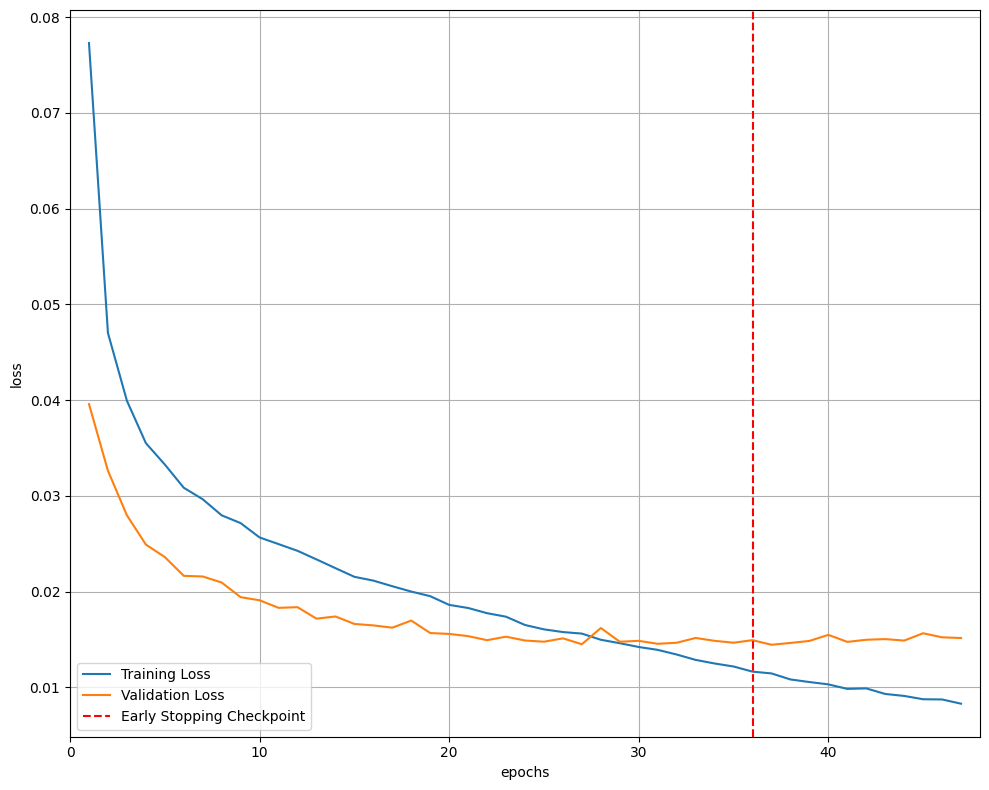

Reloaded cluster_details
train_pred: RMSE=0.080, R2=0.876, MAPE=5.651%
val_pred: RMSE=0.061, R2=0.366, MAPE=3.192%
test_pred: RMSE=0.129, R2=0.176, MAPE=5.386%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 32


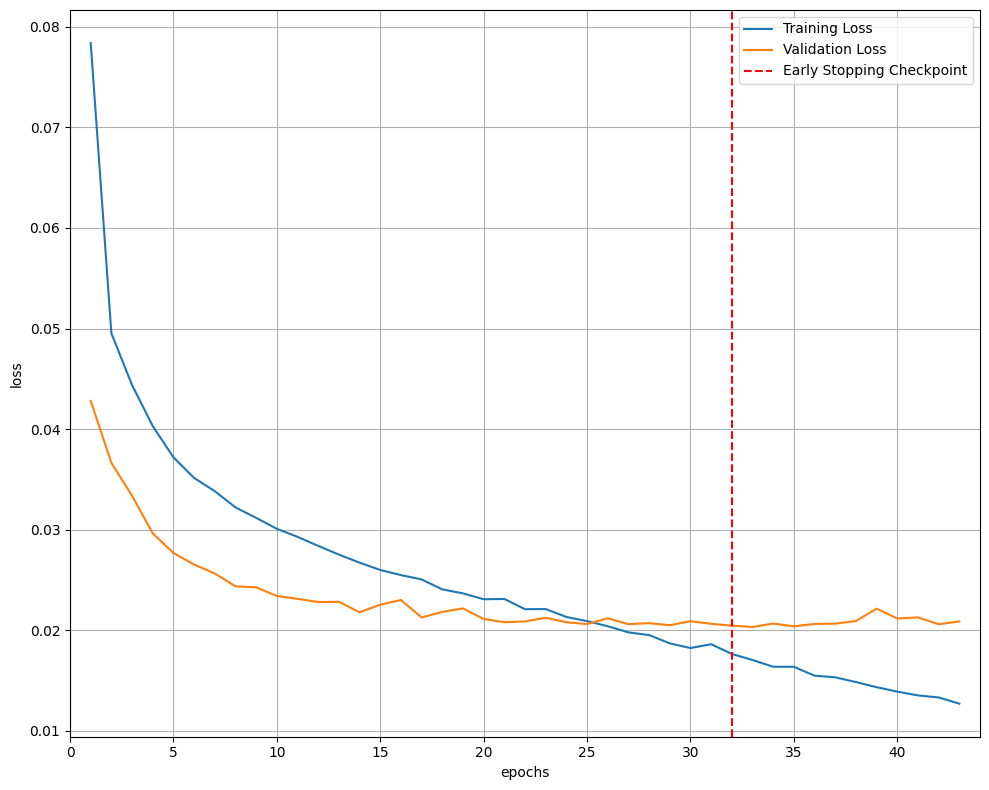

Reloaded cluster_details
train_pred: RMSE=0.083, R2=0.867, MAPE=6.021%
val_pred: RMSE=0.063, R2=0.343, MAPE=3.316%
test_pred: RMSE=0.136, R2=0.087, MAPE=5.665%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 19


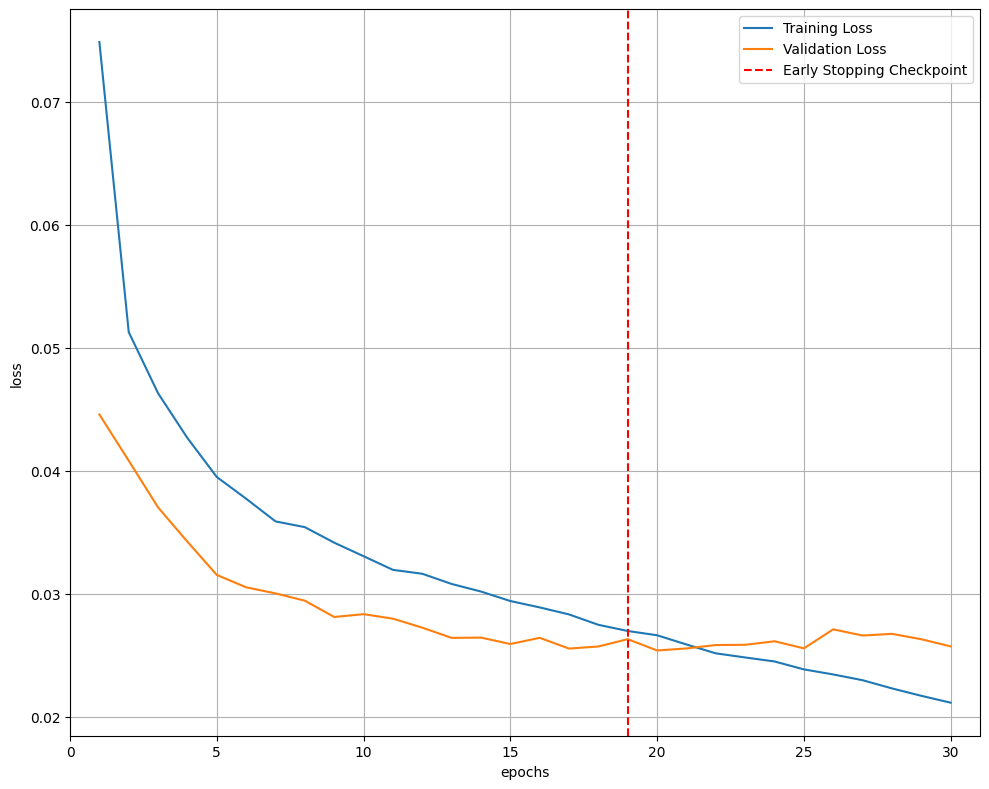

Reloaded cluster_details
train_pred: RMSE=0.075, R2=0.892, MAPE=5.561%
val_pred: RMSE=0.060, R2=0.411, MAPE=3.198%
test_pred: RMSE=0.128, R2=0.196, MAPE=5.442%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 25


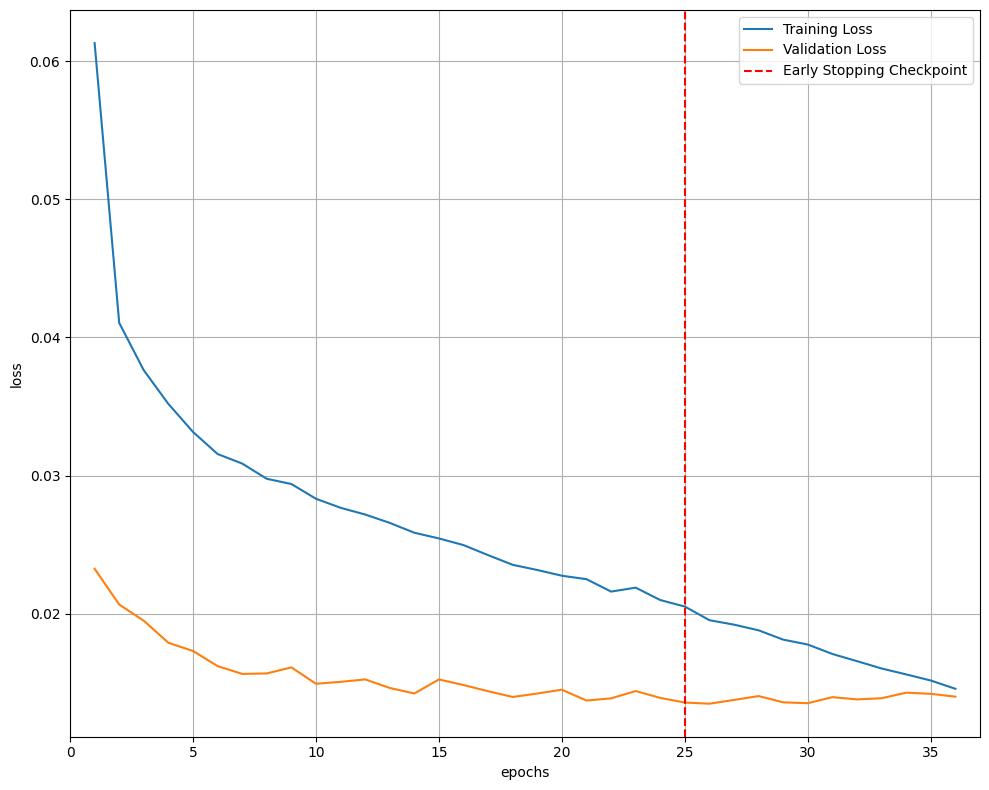

Reloaded cluster_details
train_pred: RMSE=0.078, R2=0.883, MAPE=5.679%
val_pred: RMSE=0.059, R2=0.442, MAPE=3.161%
test_pred: RMSE=0.128, R2=0.192, MAPE=5.353%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 18


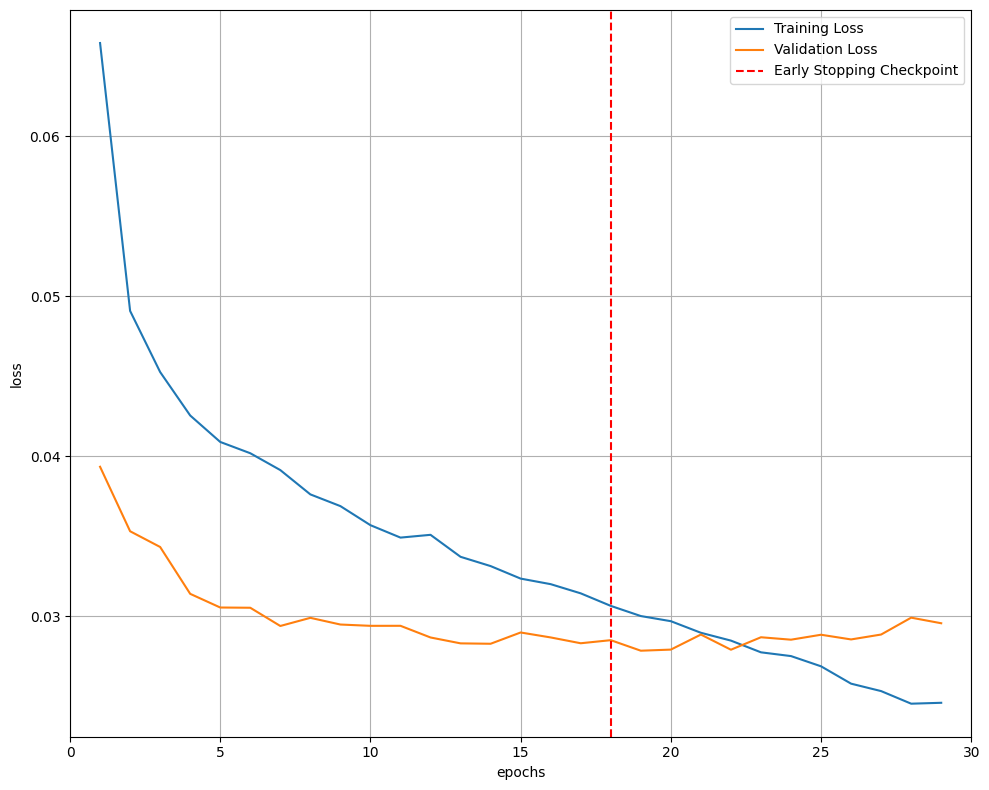

Reloaded cluster_details
train_pred: RMSE=0.078, R2=0.881, MAPE=5.789%
val_pred: RMSE=0.063, R2=0.376, MAPE=3.311%
test_pred: RMSE=0.139, R2=0.047, MAPE=5.771%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 21


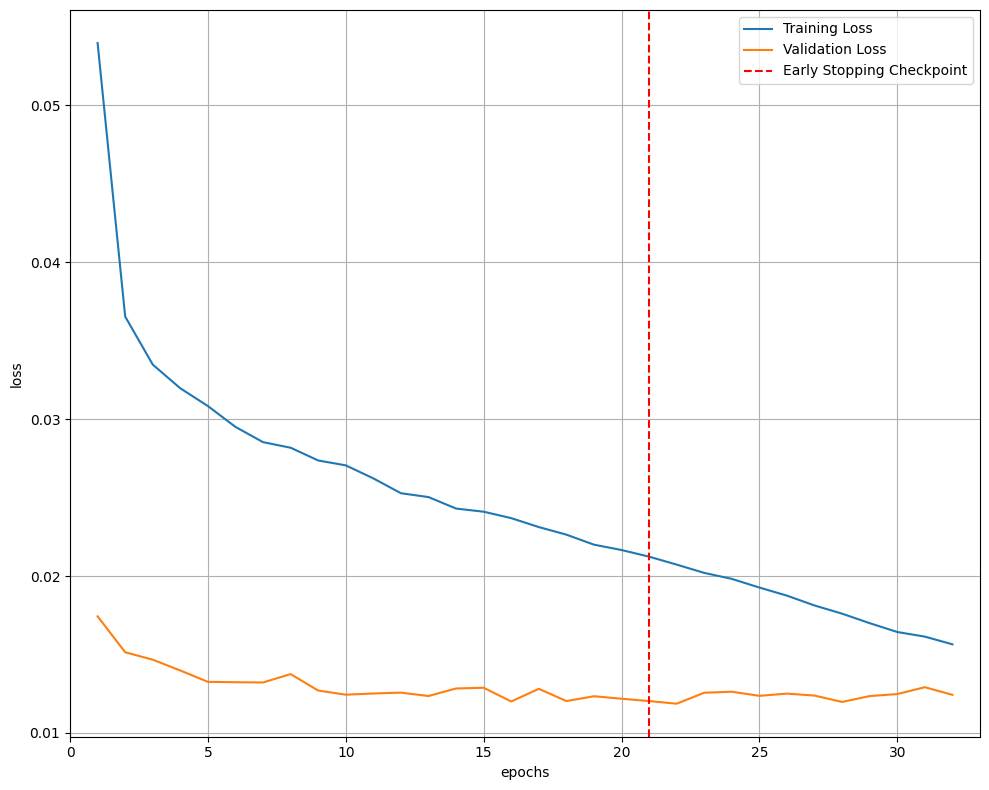

Reloaded cluster_details
train_pred: RMSE=0.079, R2=0.878, MAPE=5.748%
val_pred: RMSE=0.065, R2=0.357, MAPE=3.495%
test_pred: RMSE=0.133, R2=0.132, MAPE=5.692%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 14


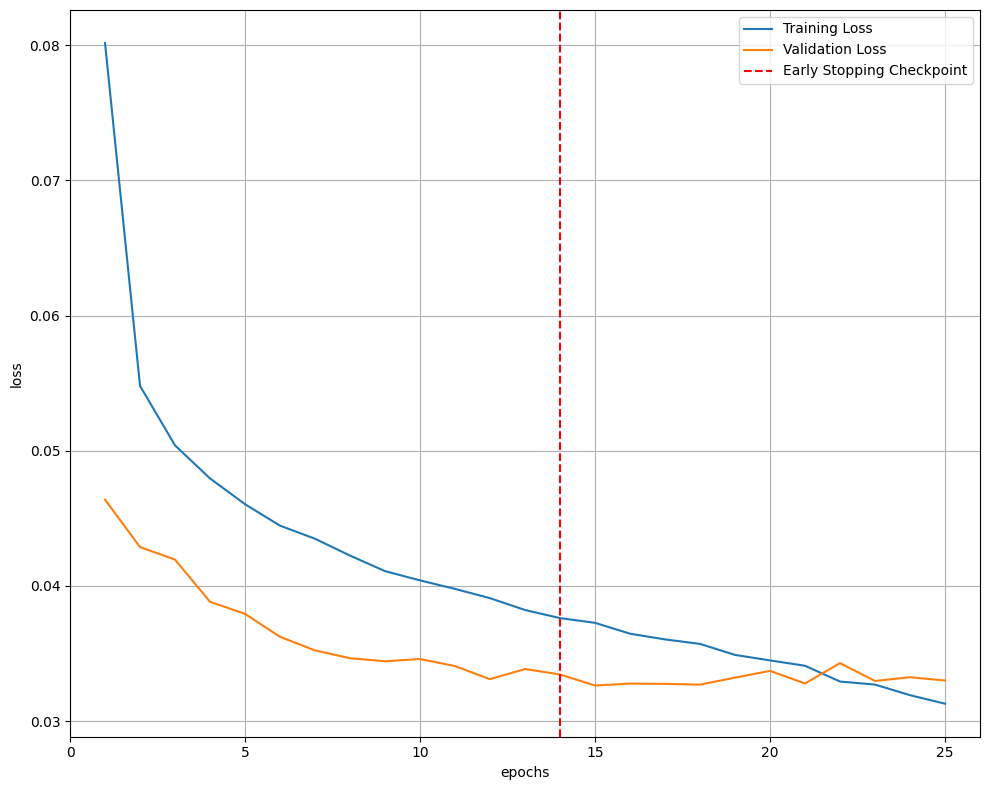

Reloaded cluster_details
train_pred: RMSE=0.075, R2=0.890, MAPE=5.715%
val_pred: RMSE=0.065, R2=0.377, MAPE=3.418%
test_pred: RMSE=0.133, R2=0.134, MAPE=5.683%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 14


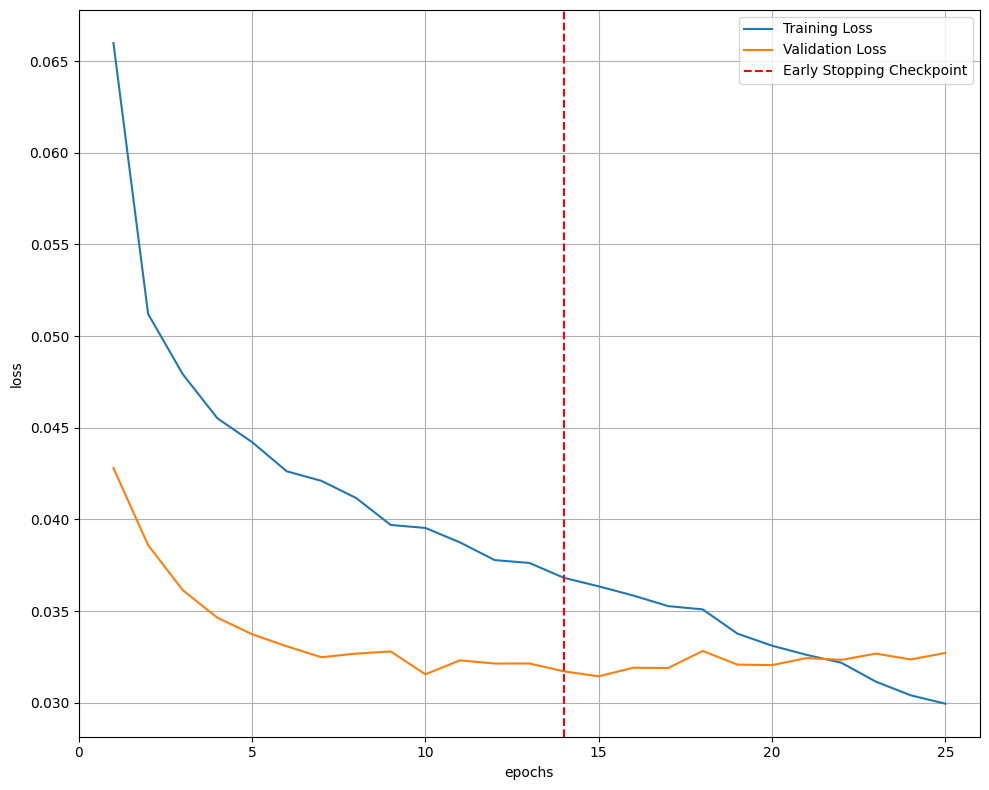

Reloaded cluster_details
train_pred: RMSE=0.079, R2=0.879, MAPE=6.014%
val_pred: RMSE=0.067, R2=0.344, MAPE=3.448%
test_pred: RMSE=0.132, R2=0.137, MAPE=5.720%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 18


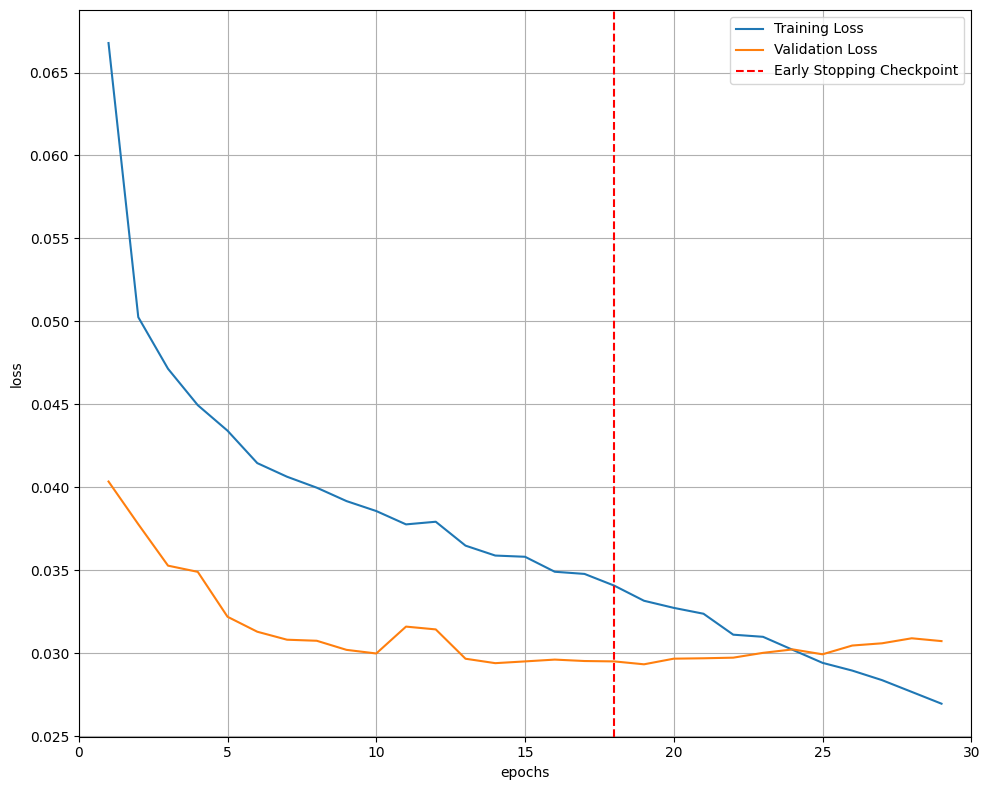

Reloaded cluster_details
train_pred: RMSE=0.084, R2=0.863, MAPE=6.197%
val_pred: RMSE=0.069, R2=0.310, MAPE=3.704%
test_pred: RMSE=0.139, R2=0.052, MAPE=5.847%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 13


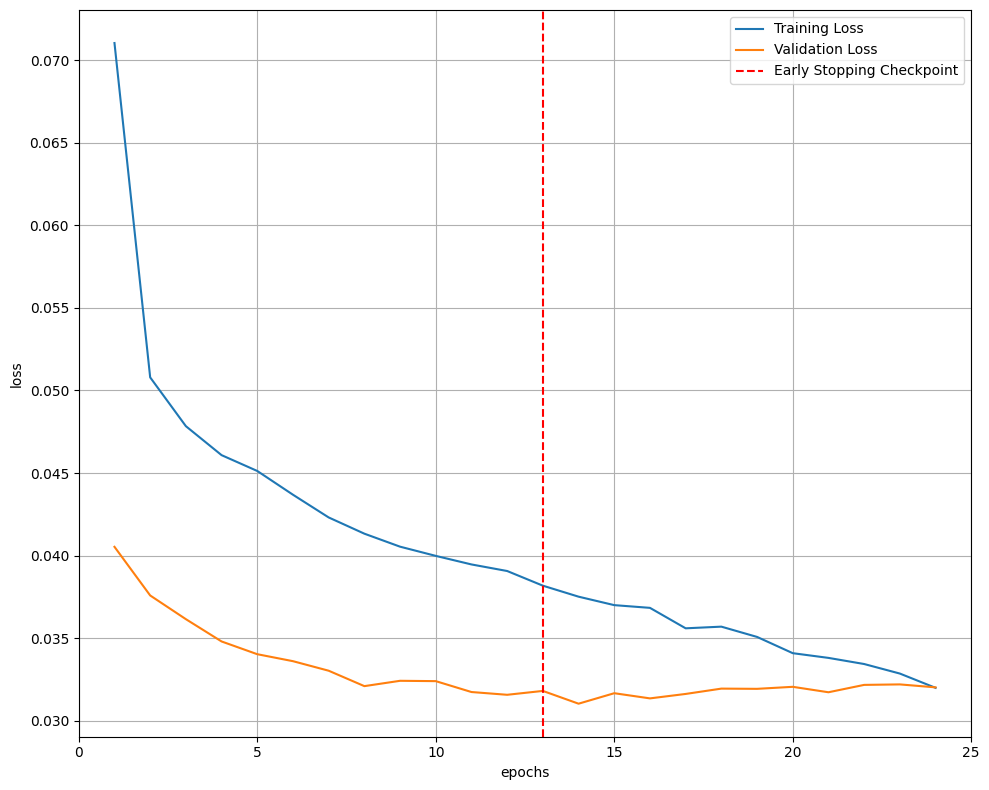

Reloaded cluster_details
train_pred: RMSE=0.080, R2=0.877, MAPE=6.066%
val_pred: RMSE=0.070, R2=0.293, MAPE=3.725%
test_pred: RMSE=0.137, R2=0.077, MAPE=5.886%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 17


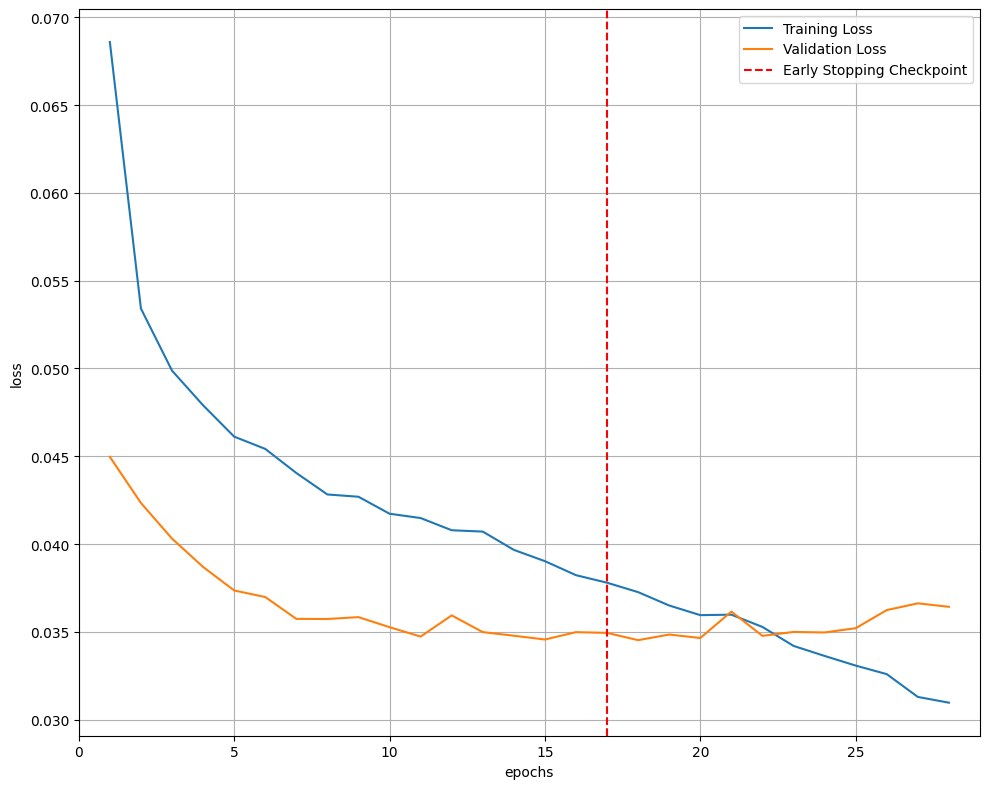

Reloaded cluster_details
train_pred: RMSE=0.083, R2=0.867, MAPE=6.251%
val_pred: RMSE=0.068, R2=0.355, MAPE=3.628%
test_pred: RMSE=0.139, R2=0.048, MAPE=6.018%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 13


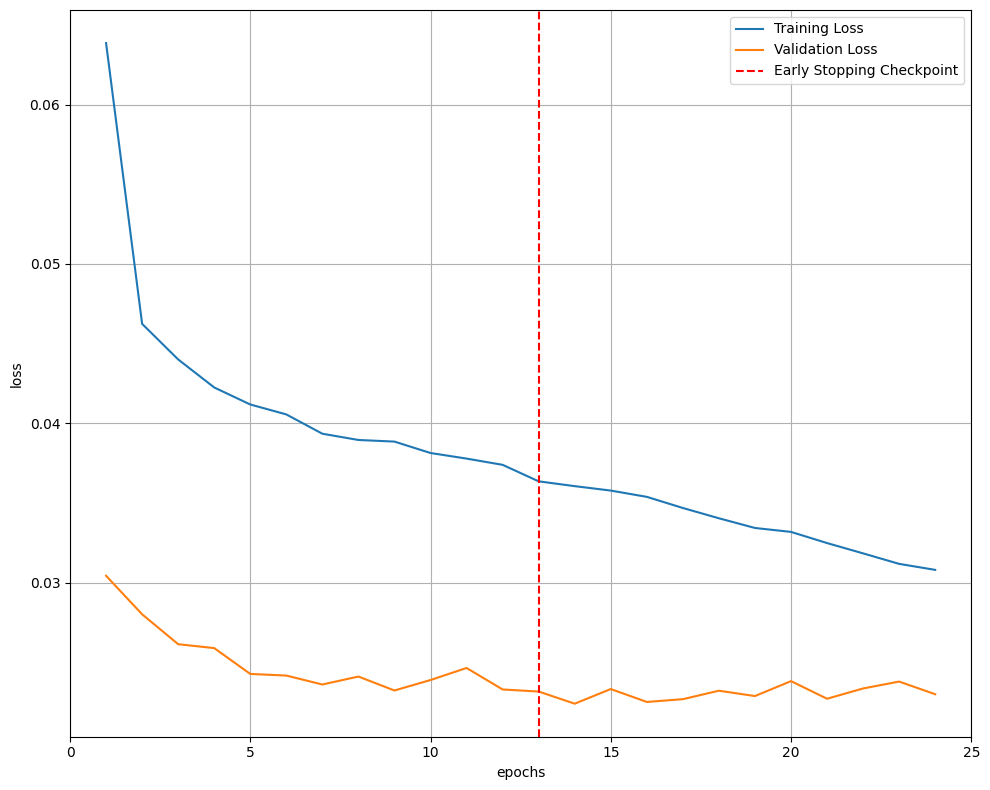

Reloaded cluster_details
train_pred: RMSE=0.083, R2=0.868, MAPE=6.277%
val_pred: RMSE=0.070, R2=0.327, MAPE=3.704%
test_pred: RMSE=0.146, R2=-0.053, MAPE=6.297%
 -- Connected to cpu -- 


/home/priya/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


  0%|          | 0/100 [00:00<?, ?it/s]

Optimal Model Epoch: 16


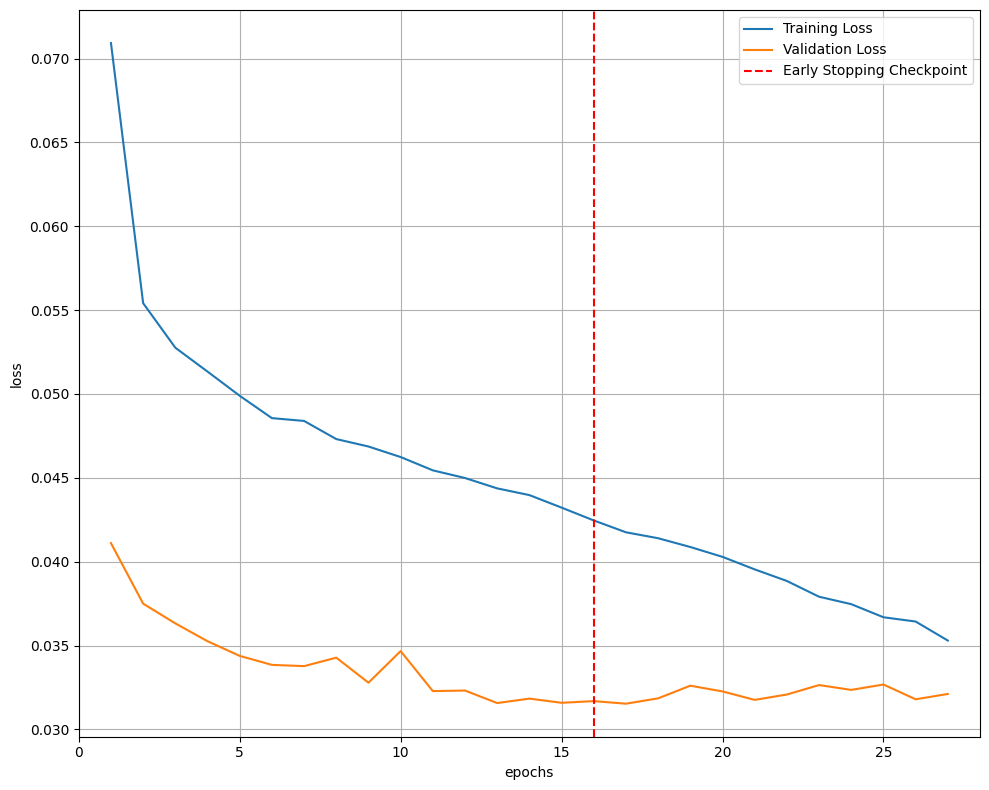

Reloaded cluster_details
train_pred: RMSE=0.088, R2=0.851, MAPE=6.652%
val_pred: RMSE=0.070, R2=0.321, MAPE=3.807%
test_pred: RMSE=0.146, R2=-0.053, MAPE=6.257%
stats saved


In [14]:
# 🚀 Run Neural Pipeline
rangeNeuralPipeline(
    ticker=ticker,
    ftraindf=ftraindf,
    fvaldf=fvaldf,
    ftestdf=ftestdf,
    cluster_details=cluster_details,
    model_dict=model_dict,
    google=1,
    pred_period=PRED_PERIOD
)

In [15]:
import pprint
pprint.pprint(model_dict)


{1: {'batch_size': 64,
     'day_target': 1,
     'device': 'cpu',
     'early_stopper': {'min_delta': 0, 'patience': 10},
     'epochs': 100,
     'input_size': 273,
     'loss_fn': 'HuberLoss',
     'model_type': 'transformer',
     'optimizer': {'learning_rate': 0.0001,
                   'optim_type': 'adamw',
                   'scheduler': 'cosine',
                   'weight_decay': 1e-05},
     'output_size': 7,
     'seed': 42,
     'transformer': {'activation': 'gelu',
                     'batch_first': True,
                     'd_model': 273,
                     'dense_layers': 2,
                     'dim_feedforward': 256,
                     'dropout': 0.2,
                     'hidden_size': 128,
                     'nhead': 7,
                     'num_encoder_layers': 2,
                     'positional_encoding': 'sinusoidal',
                     'shuffle': True},
     'verbose': 0},
 2: {'batch_size': 64,
     'day_target': 2,
     'device': 'cpu',
     'early